In [45]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

# 1D Bar Solution

In [46]:
bc = 1  # constrain (or Boundary condition) at node 1
rho = 2.7*10**(-9) # Density of the Bar
E = 71016   # Youngs Modulus
A = 306.561*44.06   # Cross Section Area
L = 1502.995  # Length of Bar
F = 3955   # Force at the tip of Bar
numElem = 4  # Number of Elements

In [47]:
le = L/numElem

elem = []
for i in range(numElem):
    elem.append([i+1,i+2])
elem

[[1, 2], [2, 3], [3, 4], [4, 5]]

In [48]:
x = Symbol('x')
Le = Symbol('Le')

# Shape Function Matrix
shape = [
    (1-x/Le),
    (x/Le)
]

# Differentiated Shape Function Matrix
shape_d = []
for i in shape:
    shape_d.append(diff(i, x))

shape = np.matrix(shape)
shape_d = np.matrix(shape_d)

shape, shape_d

(matrix([[1 - x/Le, x/Le]], dtype=object),
 matrix([[-1/Le, 1/Le]], dtype=object))

In [49]:
# Creating The Local Mass Matrix
m = np.matmul(shape.T, shape)
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        m[i,j] = simplify(integrate(m[i,j], x).subs(x, Le))
m

matrix([[Le/3, Le/6],
        [Le/6, Le/3]], dtype=object)

In [50]:
# Creating The Local Stiffness Matrix
k = np.matmul(shape_d.T, shape_d)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        k[i,j] = simplify(integrate(k[i,j], x).subs(x, Le))
k

matrix([[1/Le, -1/Le],
        [-1/Le, 1/Le]], dtype=object)

In [51]:
K = np.zeros([len(elem)+1, len(elem)+1])  # Creating initially zero matrix for global Stiffness matrix
M = np.zeros([len(elem)+1, len(elem)+1])  # Creating initially zero matrix for global Mass matrix

for i in elem:
    temp1 = k.copy()
    for a in range(temp1.shape[0]):
        for j in range(temp1.shape[1]):
            temp1[a,j] = temp1[a,j].subs(Le, le)
    K[i[0]-1:i[1], i[0]-1:i[1]] = K[i[0]-1:i[1], i[0]-1:i[1]] + (E*A) * temp1
    
    temp2 = m.copy()
    for a in range(temp2.shape[0]):
        for j in range(temp2.shape[1]):
            temp2[a,j] = temp2[a,j].subs(Le, le)
    M[i[0]-1:i[1], i[0]-1:i[1]] = M[i[0]-1:i[1], i[0]-1:i[1]] + (rho*A) * temp2

In [52]:
# Function to apply Boundary Conditions
def BC(K, bc):
    newK = []
    for i in range(len(K)):
        temp = []
        for j in range(len(K[0])):
            if not(i==bc or j==bc):
                temp.append(K[i][j])
        if temp != []:
            newK.append(temp)
    return np.matrix(newK)

In [53]:
# Global Stiffness Matrix After Applying Boundary Conditions
Kc = BC(K, bc-1)
Mc = BC(M, bc-1)

In [54]:
Lam, mode = np.linalg.eig(np.matmul(np.linalg.inv(Mc), Kc))

In [55]:
w = Lam**0.5
freq = np.sort(w/(2*np.pi))
freq

array([ 858.54965791, 2708.41510719, 4919.92288299, 7114.63992355])

In [56]:
def barFreq(n):
    return ((2*n-1)/(4*L)) * (E/rho)**0.5

n = 1
f1 = barFreq(1)

n = 2
f2 = barFreq(2)

n = 3
f3 = barFreq(3)

n = 4
f4 = barFreq(4)

f1, f2, f3, f4

(853.0582633083455, 2559.1747899250367, 4265.291316541728, 5971.4078431584185)

In [57]:
act_freq = [barFreq(1), barFreq(2), barFreq(3)]
fem_freq = []
ind = 0
for i in range(len(freq)):
    fem_freq.append(freq[i])
    ind = ind + 1
    if ind==3:
        break
    
act_freq = np.array(act_freq)
fem_freq = np.array(fem_freq)

print('Actual Frequencies:', act_freq)
print('FEM Frequencies:', fem_freq)
print('% Error:', (act_freq-fem_freq)*100/act_freq)

Actual Frequencies: [ 853.05826331 2559.17478993 4265.29131654]
FEM Frequencies: [ 858.54965791 2708.41510719 4919.92288299]
% Error: [ -0.64373031  -5.83157969 -15.34787469]


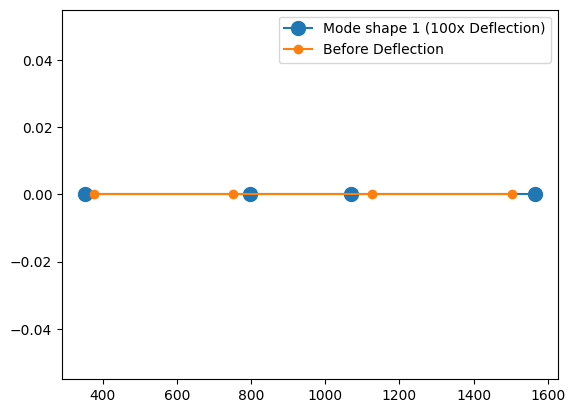

In [58]:
ModeNo = 1

Multiplier = 1*10**2
x = []
te = 0
for i in mode[:,ModeNo-1]:
    te = te + le
    x.append([te])
x = np.matrix(x)

y = []
te = 0
for i in mode[:,ModeNo-1]:
    te = te + le
    y.append([te])
y = np.matrix(y)+mode[:,ModeNo-1]*Multiplier

plt.plot(y, np.zeros([y.size,1]), marker='o', color='tab:blue', markersize=10, label=f'Mode shape {ModeNo} ({Multiplier}x Deflection)')

plt.plot(x, np.zeros([x.size,1]), marker='o', color='tab:orange', label='Before Deflection')
plt.legend()